In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import gamma
import random
from copy import deepcopy
import tqdm

## Combinatorial problem formulations and QUBO funcs

###  Number partition problem 

Given a set $S$ of $N$ positive numbers 
$S = \{ n_{0}, \ldots , n_{N-1}\}$, is there a partition of $S$ into $P$ disjoint subsets $\{ R_0, \ldots , R_{P-1} \}$, such that the sum of values in 
each set is the same. I.e., can a set of $N$ assets with values $n_0, \ldots , n_{N-1}$ fairly be distributed between $P$ parties?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{p=0}^{P-1}  \left( \sum_{i=0}^{N-1} n_{i} x_{i, p} - \frac{1}{P} \sum_{i=0}^{N-1} n_{i} \right)^2 + M \sum_{i=0}^{N-1}  \left( 1- \sum_{p=0}^{P-1} x_{i, p} \right)^2 \, ,
\end{align}

and the decision variable $x_{i, p} \in \{0,1\}$ is defined as

\begin{align}
	x_{i, p} = 
    \begin{cases}
	1 & \text{if number } n_i \text{ of set } S \text{ is in set } R_p \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

- $P=4$: Number of subsets.
- $N$: Number of values in set $S$.
- ${\rm{bits}} = N \cdot P$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

Expanding the Hamiltonians $H = H_o + M H_p$:


$$
H_o = P\alpha^2 + \sum_{i,p} (n_i^2 - 2\alpha n_i) x_{ip} + \sum_{p, i \ne i^{'}} n_i n_{i^{'}} x_{ip} x_{i^{'}p}
$$
where $\alpha = \sum_i n_i/P$.

$$
H_p = N - \sum_{i,p} x_{ip} + \sum_{i, p \ne p^{'}} x_{ip} x_{ip^{'}}
$$
### Traveling salesman problem

Given a graph $G=(V,E)$ with $N=|V|$ nodes (cities), what is the cheapest hamiltonian cycle, considering the edge $e_{i,j}$ as the cost from going from city $i$ to city $j$?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}  + M \bigg[ \sum_{i=1}^{N}  \left( 1- \sum_{t=1}^{N} x_{t, i} \right)^2 + \sum_{t=1}^{N}  \left( 1- \sum_{i=1}^{N} x_{t, i} \right)^2  \bigg]\, ,
\end{align}

and the decision variable $\{x_{t, i}\}_{i,t=1,\dots,N} \in \{0,1\}^{N^2}$ is defined as

\begin{align}
	x_{t, i} = 
    \begin{cases}
	1 & \text{if city } i \text{ is visited at time step } t \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

The constraint enforces the decision matrix $[x]_{t, i}$ to be a permutation matrix, ordering the temporal visit of each city.

- $N$: Number of cities/nodes.
- ${\rm{bits}} = N^2$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.


Expanding the Hamiltonians $H = H_o + M H_p$:

$$
H_o = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}
$$

$$
H_p = 2N - 2\sum_{t,i}^{N} x_{ti} + \sum_{t,i}^{N} \biggl( \sum_{i^{'} \ne i}^{N} x_{ti} x_{ti^{'}} + \sum_{t^{'} \ne t}^{N} x_{ti} x_{t^{'}i} \biggr)
$$
where $N = N_{cities}$.

In [2]:
### QUBO functions

def L1_norm(Q, const):
    return const + np.sum(np.abs(Q))

def L1_norm_hot(Q, const, n_bits, temperature, max_prob_inf):
    return L1_norm(Q, const) + temperature*(n_bits*np.log(2) - np.log(max_prob_inf))

def build_numbs_set(N, P, seed):
    random.seed(seed)
    numbs = [int(1000*random.uniform(0.0, 1.0)) for _ in range(N)]
    total = sum(numbs)
    if numbs[-1] - (total % P) > 1:
        numbs[-1] -= (total % P)
    else:
        numbs[-1] += (P - (total % P))
    total = sum(numbs)
    return numbs

def idx_onehot(i, p, P):
    return i*P + p

def symmetrize(Q):
    return (Q + Q.T)/2

# NPP specific

def build_obj_NPP(numbs, N, P):
    H = np.zeros((N*P, N*P))
    alpha = np.sum(numbs)/P

    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = numbs[i]**2 - 2*alpha*numbs[i]
            for i_prime in range(N):
                if i_prime == i:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i_prime, p, P)] = numbs[i] * numbs[i_prime]
    const = P*alpha**2
    H = symmetrize(H)
    return H, const

def build_pen_NPP(N, P):
    H = np.zeros((N*P, N*P))
    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = -1
            for p_prime in range(P):
                if p_prime == p:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i, p_prime, P)] = 1
    const = N
    H = symmetrize(H)
    return H, const

def get_QUBO_NPP(N, P, M, seed, objective = True, penalization=True):
    # build a NPP QUBO with N integers, P partitions, M penalty factor, for problem identified with seed
    Q, const = np.zeros((N*P, N*P)), 0
    if objective:
        numbs = build_numbs_set(N, P, seed)
        Ho, const_o = build_obj_NPP(numbs, N, P)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_NPP(N, P)
        Q += M*Hp
        const += M*const_p
    return Q, const

# TSP specific


def build_adjacency(Nc, seed, circle_flag):
    if circle_flag:
        # trivial construction of adj. matrix of graph with N cities on a circle. Modify this function to get more complex structures
        coordinates = [(1_000_000 * np.cos((index / Nc) * 2 * np.pi), 1_000_000 * np.sin((index / Nc) * 2 * np.pi)) for index in range(Nc)]
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    else:
        # random construction of the adjacency matrix, based on euclidian distance. (cities are uniformly randomly placed inside a square)
        np.random.seed(seed)
        coordinates = 1e6 * np.array( [np.random.uniform(low = -1, high = 1, size = 2) for i in range(Nc)] )
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    return np.array(distance_table)

def build_obj_TSP(distances, Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot((t+1)%Nc, i_prime, Nc)] = distances[i, i_prime]
    H = symmetrize(H)
    const = 0
    return H, const

def build_pen_TSP(Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            H[idx_onehot(t, i, Nc), idx_onehot(t, i, Nc)] = -2
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot(t, i_prime, Nc)] += 1
            for t_prime in range(Nc):
                if t_prime != t:
                    H[idx_onehot(t, i, Nc), idx_onehot(t_prime, i, Nc)] += 1
    const = 2*Nc
    H = symmetrize(H)
    return H, const

def get_QUBO_TSP(Nc, M, seed, circle_flag = False, objective = True, penalization=True):
    # build a TSP QUBO with Nc cities, M penalty factor, for problem identified with seed
    Q, const = np.zeros((Nc**2, Nc**2)), 0
    if objective:
        distances = build_adjacency(Nc, seed, circle_flag)
        Ho, const_o = build_obj_TSP(distances, Nc)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_TSP(Nc)
        Q += M*Hp
        const += M*const_p
    return Q, const


### Generally useful functions

def nearest_to(ref_array, element):
    """
    Given a requested element (e.g. energy), returns the nearest value in a reference array, together with its position in the array
    """
    diff = np.abs(ref_array - element)
    idx = np.where(diff == np.min(diff))[0][0]
    return idx, ref_array[idx]

def remove_outliers(l, whisker_len = 1.5):
    q1, q3 = np.percentile(l, [25, 75])
    thres = q3 + whisker_len*(q3-q1)
    l = np.delete(l, l > thres)
    return l, thres

## Read data

In [3]:
## import data
directory = "../data/dichotomic_NPP/1/"
l_measures = 70 # it is the number of M-trials with dichotomic search [ i.e. the max of len( list( summary['measurements'].keys() ) )]
n_instances = 128

data_M, data_temp, data_rate, data_par = -np.ones((n_instances, l_measures)), -np.ones((n_instances, l_measures, 2)), -np.ones((n_instances, l_measures)), np.ndarray((n_instances, 2), dtype = int) # data_par is N, P at final index, in this order
data_values = {}


import os, json
files = np.sort([file for file in os.listdir(directory) if file[-4:] == "json"])


max_len_Ms = 0
for inst_idx, file in enumerate(files):

    filename =  directory+file
    if not os.path.isfile(filename):
        print(f"{filename} doesn't exist")
        continue

    with open(filename, 'r') as fp:
        summary = json.load(fp)
        data_par[inst_idx] = summary['N'], summary['P']
        Ms = list(summary['measurements'].keys())
        if len(Ms) > max_len_Ms:
            max_len_Ms = len(Ms)
        assert len(Ms) <= l_measures
        data_M[inst_idx, :len(Ms)] = Ms
        data_values[inst_idx] = summary['values']

        for M_idx, M in enumerate(Ms):
            data_temp[inst_idx, M_idx] = summary['measurements'][str(M)]['temperature_start'], summary['measurements'][str(M)]['temperature_end']
            data_rate[inst_idx, M_idx] = summary['measurements'][str(M)]['rate']
print(f'Read data --> Done')


data_M, data_temp, data_rate = data_M[:, :max_len_Ms], data_temp[:, :max_len_Ms], data_rate[:, :max_len_Ms]
l_measures = max_len_Ms


Read data --> Done


In [4]:
#idx, el_nearest = nearest_to(array, element)

def simulate_bisection(probability, inst_idx):
    M_history, rate_history, temp_i_history, temp_f_history = [], [], [], []
    M_low, M_high = 0, 2e9
    while True:
        M = int(.5 * (M_low + M_high))
        M_idx, M = nearest_to(data_M[inst_idx], M)
        rate_M = data_rate[inst_idx, M_idx]
        M_history.append(M)
        rate_history.append(rate_M)
        temp_i_history.append(data_temp[inst_idx, M_idx, 0])
        temp_f_history.append(data_temp[inst_idx, M_idx, 1])
        if rate_M > probability:
            M_high = M
        else:
            M_low = M
        if M_high - M_low < 100:
                break
    return np.array(M_history), np.array(rate_history), np.swapaxes( np.vstack((temp_i_history, temp_f_history)) , 0, 1)


prob = .5 # .25, .5 or .75
inst_idx = 0
M_history, rate_history,temps_history = simulate_bisection(prob, inst_idx)

## Dichotomic search overview

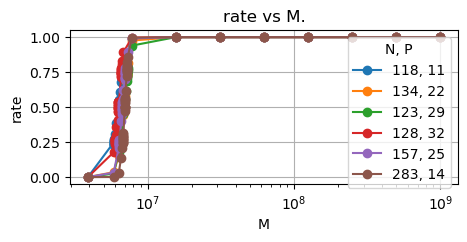

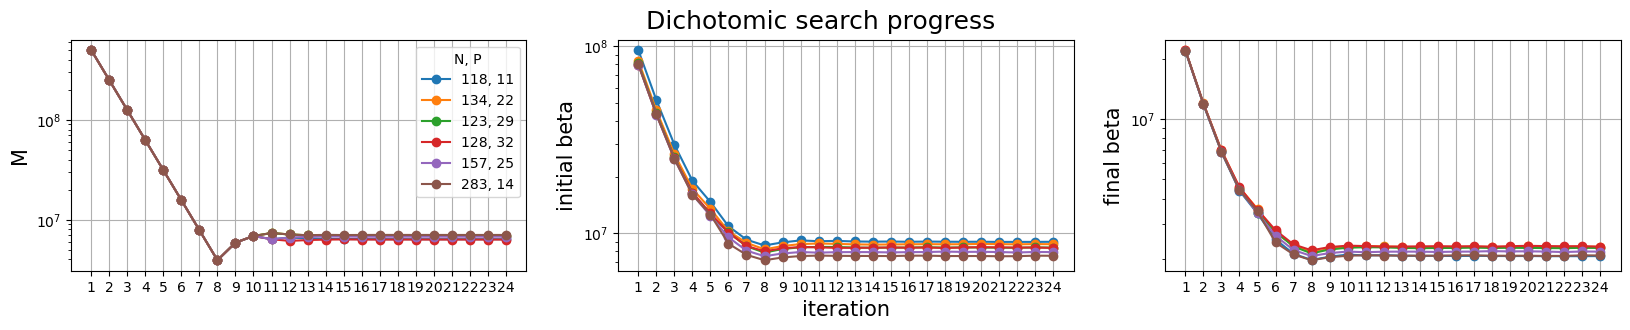

In [5]:
instances = [0, 1, 2, 3, 7, 8]


fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111)
for inst_idx in instances:
    mask = data_M[inst_idx] > 0
    ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
ax.set_ylabel("rate")
ax.set_xlabel("M")
ax.set_title(f"rate vs M.")
ax.set_xscale("log")
ax.legend(fontsize = 10, loc='best', title = "N, P")
plt.grid()
plt.show()

prob_target = .5
jump_first = 1
fig = plt.figure(figsize=(20,3))
plt.suptitle("Dichotomic search progress", fontsize = 18)
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
for inst_idx in instances:
    M_history, rate_history, temps_history = simulate_bisection(prob_target, inst_idx)
    ax1.plot(np.arange(jump_first, len(M_history)), M_history[jump_first:], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
    ax2.plot(np.arange(jump_first, len(M_history)), temps_history[jump_first:, 0], "-o")
    ax3.plot(np.arange(jump_first, len(M_history)), temps_history[jump_first:, 1], "-o")
ax2.set_xlabel("iteration", fontsize = 15)
ax1.set_ylabel("M", fontsize = 15)
ax2.set_ylabel("initial beta", fontsize = 15)
ax3.set_ylabel("final beta", fontsize = 15)
for ax in [ax1, ax2, ax3]:
    ax.set_yscale("log")
    ax.set_xticks(np.arange(jump_first, len(M_history)))
    ax.grid()
ax1.legend(fontsize = 10, loc='best', title = "N, P")
plt.show()

## Apply M algorithm

In [ ]:
# apply M method to DA instances
from myalgo import M_method_opt, M_method_feas

# set parameters: temperature, min_probabilty, max_energy and violation_peaks
problem_type = "NPP"

E_LB = 0
peak_max = 4
min_pfeas = .5 # eta
E_f = 1e9 #? should be high since DA data refer to feasible only (need to study M(Ef) behavior to understand it better)

for inst_idx in range(2):
    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    N, P = data_par[inst_idx]
    size = (N, P)
    numbers_NPP = data_values[inst_idx]

    M, eta_guarantee = M_method_opt(size, problem_type, numbers_NPP, "numbers", beta, peak_max, min_pfeas, E_f, E_LB)
    print(M)


(118, 11)
17231722.82800078392
(134, 22)
22020181.175321340561


17207724.26575422287 0.5


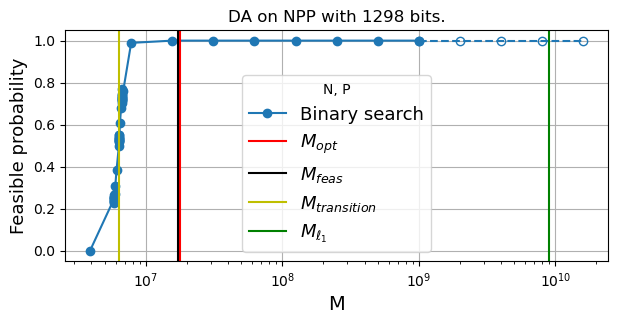

In [9]:
# set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
problem_type = "NPP"
E_LB = 0
peak_max = 4
min_pfeas = .5 # eta
E_f = 1e10

for inst_idx in np.arange(1):
    N, P = data_par[inst_idx]
    size = (N, P)
    numbers_NPP = data_values[inst_idx]

    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta_avg = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    M, eta_guarantee = M_method_opt(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_f, E_LB)
    M_feas, eta_guarantee = M_method_feas(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_LB)
    #M_bad, eta_guarantee = M_method_badtail(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_f, E_LB)

    print(M_feas, eta_guarantee)

    M_trans_idx, _ = nearest_to(data_rate[inst_idx], min_pfeas)
    M_trans = data_M[inst_idx, M_trans_idx]
    # beta_trans = 1/data_temp[inst_idx, M_trans_idx, 1]
    # M_UB_trans = M_method_DA(size, problem_type, numbers_NPP, beta_trans, peak_max, min_pfeas, E_f, E_LB

    # L1 norm estimate of M
    Q_obj, const_obj = build_obj_NPP(numbers_NPP, N, P)
    M_L1 = L1_norm(Q_obj, const_obj)
    M_L1_hot = L1_norm_hot(Q_obj, const_obj, N*P, 1/beta_avg, max_prob_inf = min_pfeas)

    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot(111)
    mask = data_M[inst_idx] > 0
    #ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
    ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = "Binary search")
    ax.axvline(M, color = "r", label = r"$M_{opt}$")
    ax.axvline(M_feas, color = "k", label = r"$M_{feas}$")
    #ax.axvline(M_bad, linestyle = "--", color = "g", label = r"$M^*_{badtail}$")
    ax.axvline(M_trans, color = "y", label = r"$M_{transition}$")
    ax.axvline(M_L1_hot, color = "g", label = r"$M_{\ell_1}$")
    
    fake_points = np.array([1, 2, 4, 8, 16])*1e9
    ax.plot(fake_points, np.ones((len(fake_points))), "--o", color = "C0", fillstyle='none')
    
    ax.set_ylabel("Feasible probability", fontsize = 13)
    ax.set_xlabel("M", fontsize = 14)
    ax.set_title(f"DA on NPP with {N*P} bits.")
    ax.set_xscale("log")
    ax.legend(fontsize = 13, loc='best', title = "N, P")
    plt.grid()
    plt.show()

#fig.savefig("NPP_dichotomic")

## Scaling ratio M / M_trans

100%|██████████| 128/128 [06:16<00:00,  2.94s/it]


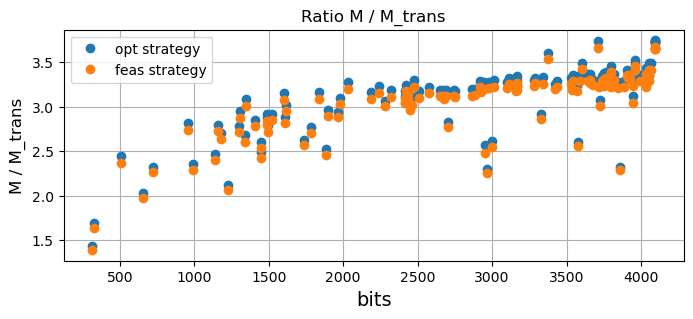

In [8]:
# ratio M / M_transition  ---  comparing the optimality strategy, with a high E_f to capture hopefully the whole feasible subspace, and the feasibility strategy
# (sorted according to number of bits) #TODO maybe according to N or P can be meaningful

ratios_M, ratios_M_feas, bits_axes = np.ndarray((n_instances)), np.ndarray((n_instances)), np.ndarray((n_instances))

problem_type = "NPP"
E_f = 1e10
min_pfeas = 0.5 # eta
E_LB = 0
peak_max = 4

for inst_idx in tqdm.tqdm(range(n_instances)):
    N, P = data_par[inst_idx]
    size = (N, P)
    bits_axes[inst_idx] = N*P
    ### compute transition M
    M_idx_trans, rate_trans = nearest_to(data_rate[inst_idx], .5)
    M_trans = data_M[inst_idx, M_idx_trans]
    ### compute M from recipe
    numbers_NPP = data_values[inst_idx]
    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta_avg = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    M, eta_guarantee = M_method_opt(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_f, E_LB)
    M_feas, eta_guarantee = M_method_feas(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_LB)
    # beta_single = 1 / np.mean(data_temp[N_idx, M_idx_trans, inst_idx, :, 1])
    # M_estimated_single = M_method_opt(size, problem_type, numbers_NPP, "numbers", beta_single, peak_max, min_pfeas, E_f, E_LB)

    ratios_M[inst_idx] = M / M_trans
    ratios_M_feas[inst_idx] = M_feas / M_trans
    
idx_sorted = np.argsort(bits_axes)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"Ratio M / M_trans")                   
ax.plot(bits_axes[idx_sorted], ratios_M[idx_sorted],"o", label = "opt strategy")
ax.plot(bits_axes[idx_sorted], ratios_M_feas[idx_sorted],"o", label = "feas strategy")
ax.set_ylabel("M / M_trans", fontsize=12)
ax.set_xlabel("bits",fontsize=14)
ax.legend(fontsize = 10, loc='best')
#plt.yscale('log')
plt.grid()
